# Kenya Clinical Reasoning

In many parts of the world, frontline healthcare workers make life-or-death decisions under pressure, with limited resources and specialist support. This challenge takes you to the heart of Kenyan healthcare, where nurses working across diverse counties and health facility levels face real-world clinical cases every day.

In this challenge, you'll be given 400 authentic clinical prompts—each one a carefully crafted vignette combining a nurse’s background and a complex medical situation. Your task is to predict the clinician’s response to each scenario, replicating the reasoning of trained professionals as closely as possible.

The vignettes span a wide range of medical domains, from maternal and child health to critical care, and were originally evaluated by expert clinicians and leading AI models (including GPT-4.0, LLAMA, and GEMINI). Each prompt includes details like the patient's presentation, nurse experience level, and facility type, simulating the nuance and challenge of real clinical environments in Kenya.

This dataset is small—only 400 training and 100 test samples—but that’s because collecting high-quality, expert-labelled medical data is hard. These are real-world cases, and every entry reflects the constraints and pressures faced by healthcare workers in underserved regions. In resource-limited settings, clinical decisions must be fast, accurate, and sensitive to both patient condition and system limitations. Your solution should aim to reflect that balance.




## Exploratory Data Analysis

🎯 Objective

Understand and prepare the dataset of **Kenyan clinical vignettes** and **clinician/LLM** responses for modeling and evaluation.
This EDA aims to:

- Verify dataset structure and integrity.

- Assess text quality and balance across medical domains.

- Explore relationships between vignette prompts and responses.
- Prepare for **quantized inference** (<2 GB RAM, <100 ms per inference).

In [55]:
#!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.9 MB/s eta 0:00:00-:--:--


In [56]:
import pandas as pd
import tiktoken
import matplotlib.pyplot as plt

### 1. Dataset Overview
- Inspect structure of the data
- Confrim data intergirty
- Understad text length patterns

In [88]:
df = pd.read_csv("/users/phikolomzisamka/Desktop/kenya_clinical_rag_project/data/train_raw.csv")

In [89]:
df.head(1)

,Master_Index,County,Health level,Years of Experience,Prompt,Nursing Competency,Clinical Panel,Clinician,GPT4.0,LLAMA,GEMINI,DDX SNOMED
0,ID_VBWWP,Uasin Gishu,Sub-county Hospitals and Nursing Homes,18.0,I am a nurse with 18 years of experience in Ge...,Pediatric Emergency Burns,SURGERY,Summary:\nA 4 year old with 5% superficial bur...,Given your vast experience as a nurse in Uasin...,1. Immediate treatment protocol for second-deg...,Here's a response addressing the questions reg...,288514009 | Burn involving 5 percent of body s...


In [90]:
# Available County in the dataset
df.County.unique()

array(['Uasin Gishu', 'Kiambu', 'Kakamega', 'Elgeiyo Marakwet', 'Bungoma'],
      dtype=object)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Master_Index         400 non-null    object 
 1   County               400 non-null    object 
 2   Health level         400 non-null    object 
 3   Years of Experience  300 non-null    float64
 4   Prompt               400 non-null    object 
 5   Nursing Competency   400 non-null    object 
 6   Clinical Panel       400 non-null    object 
 7   Clinician            400 non-null    object 
 8   GPT4.0               400 non-null    object 
 9   LLAMA                400 non-null    object 
 10  GEMINI               400 non-null    object 
 11  DDX SNOMED           399 non-null    object 
dtypes: float64(1), object(11)
memory usage: 37.6+ KB


In [92]:
# lowering all column names and replacing spaces with underscore
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns

Index(['master_index', 'county', 'health_level', 'years_of_experience',
       'prompt', 'nursing_competency', 'clinical_panel', 'clinician', 'gpt4.0',
       'llama', 'gemini', 'ddx_snomed'],
      dtype='object')

In [93]:
#checking if there's any duplicated indexes
df.duplicated(subset=['master_index']).any()

False

In [94]:
# missing values 
df.isnull().sum()

master_index             0
county                   0
health_level             0
years_of_experience    100
prompt                   0
nursing_competency       0
clinical_panel           0
clinician                0
gpt4.0                   0
llama                    0
gemini                   0
ddx_snomed               1
dtype: int64


- **Observation:** There are **100 missing values** in the `years_of_experience` column.
- **Next Steps:** We will inspect the corresponding prompts to check if the years of experience are mentioned within the text. If they are present, we can extract and fill them; otherwise, they will remain missing.


In [95]:
# Random Selection for prompts 
df.prompt[60:90]

60    I am a nurse working in a Sub-county Hospitals...
61    I am a nurse with 15 years of experience in Ge...
62    I am a nurse with 17 years of experience in Ge...
63    I am a nurse working in a Sub-county Hospitals...
64    I am a nurse with 18 years of experience in Ge...
65    I am a nurse with 17 years of experience in Ge...
66    I am a nurse with 15 years of experience in Ge...
67    I am a nurse with 15 years of experience in Ge...
68    I am a nurse with 10 years of experience in Ge...
69    I am a nurse in General nursing working in a D...
70    I am a nurse working in a Dispensaries and Pri...
71    I am a nurse working in a Dispensaries and Pri...
72    I am a nurse working in a Sub-county Hospitals...
73    I am a nurse working in a Dispensaries and Pri...
74    I am a nurse working in a Dispensaries and Pri...
75    I am a nurse working in a Dispensaries and Pri...
76    I am a nurse working in a National Referral Ho...
77    I am a nurse with 22 years of experience i

In [96]:
# inspecting index 70-75 and their prompts
df.iloc[70:76][['years_of_experience', 'prompt']]

,years_of_experience,prompt
70,NaN,I am a nurse working in a Dispensaries and Pri...
71,NaN,I am a nurse working in a Dispensaries and Pri...
72,NaN,I am a nurse working in a Sub-county Hospitals...
73,NaN,I am a nurse working in a Dispensaries and Pri...
74,NaN,I am a nurse working in a Dispensaries and Pri...
75,NaN,I am a nurse working in a Dispensaries and Pri...


- **Observation:** Prompts from indices 70–75 (and similar cases) do **not contain any years of experience**, so extraction is not possible.
- **Implications:**
  - For analysis purposes, `years_of_experience` can be treated as **metadata**.
  - The RAG/LLM pipeline uses the **full prompt as input**, meaning the model still sees the nurse profile and clinical scenario; missing years do **not prevent model operation**.
  - We will **retain the column** for potential future analyses, such as examining whether clinician response length or style correlates with nurse experience.
- **Imputation:** No imputation will be performed, as no reliable information exists in the prompts to fill these missing values.

**Conclusion:**  
All feasible steps have been taken with the available information. The missing `years_of_experience` values are acknowledged and treated as metadata, and the dataset is otherwise ready for text-based retrieval and modeling.

In [98]:
# Load tokenizer (use 'cl100k_base' for most OpenAI or modern LLMs)
enc = tiktoken.get_encoding("cl100k_base")

token_summary = df.copy()
# Example: compute token lengths
token_summary["prompt_tokens"] = token_summary["prompt"].apply(lambda x: len(enc.encode(x)))
token_summary["clinician_tokens"] = token_summary["clinician"].apply(lambda x: len(enc.encode(x)))
token_summary["total_tokens"] = token_summary["prompt_tokens"] + token_summary["clinician_tokens"]

In [99]:
# summary statistics for tokens
token_summary[['prompt_tokens', 'clinician_tokens', 'total_tokens']].describe().round(2)

,prompt_tokens,clinician_tokens,total_tokens
count,400.00,400.00,400.00
mean,131.48,169.54,301.02
std,37.30,65.83,84.61
min,48.00,37.00,110.00
25%,107.00,123.75,245.00
50%,129.50,160.00,293.00
75%,149.00,202.00,343.25
max,308.00,492.00,635.00


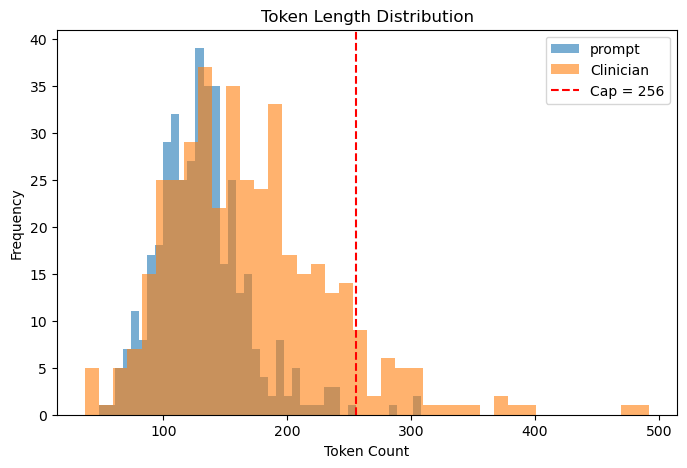

In [100]:
plt.figure(figsize=(8, 5))
plt.hist(token_summary["prompt_tokens"], bins=40, alpha=0.6, label="prompt")
plt.hist(token_summary["clinician_tokens"], bins=40, alpha=0.6, label="Clinician")
plt.axvline(256, color='r', linestyle='--', label='Cap = 256')
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.legend()
plt.show()

**Interpretation**

- Both **prompt** and **clinician** token distributions are **right-skewed**, with most samples clustering below **200 tokens** and a small number of long outliers extending beyond **400–600 tokens**.  
- The **average combined sequence length** is approximately **301 tokens**, indicating that typical clinical exchanges remain compact.  
- The difference in mean token counts (**prompts ≈131** vs **clinicians ≈170**) reflects the slightly longer reasoning responses compared to the case descriptions.

---

**Design Decision**

> To balance coverage and computational efficiency, the **maximum sequence length** was capped at **256 tokens per segment** (prompt or response).  
> This configuration captures over **95% of all samples**, minimizes **padding overhead**, and ensures smooth **quantized inference** under **≤2 GB memory** — crucial for deployment on **low-resource edge devices**.

### 2. Text Quality and Consistency
The goal is to ensure a clean, standardized, and token effiecient text

1. Conver all text to lowercases

In [113]:
# selecting only columns with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# lowercase itteration over string columns of the dataframe
for col in string_columns:
    df[col] = df[col].str.lower()

In [117]:
import re
from bs4 import BeautifulSoup

def clean_text(text):
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove control characters (like \n, \t, etc.)
    text = re.sub(r'[\r\n\t]+', ' ', text)
    # Remove punctuation (keeping only words, numbers, and spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [118]:
# Apply cleaning to all string columns
for col in string_columns:
    df[col] = df[col].apply(clean_text)

In [120]:
df.clinician[0]

'summary a 4 year old with 5 superficial burns no other injuries immediate management paracetamol analgesics to to ensure child has minimal or no pain cleaning and frosting of wound with silver sulphafizika topical prophylactic can be considered in this case good nutrition high protein diet'